# Install*

In [ ]:
# Tokenizer library 설치
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 2.9MB/s 


# Evn*

In [ ]:
# imports
import argparse
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm, trange

In [ ]:
# 환경 설정
args = {
    # random seed value
    "seed": 1234
}
args = argparse.Namespace(**args)

print(args)

Namespace(seed=1234)


In [ ]:
# random seed 설정
random.seed(args.seed)
np.random.seed(args.seed)
tf.random.set_seed(args.seed)

In [ ]:
# gpu 사용량 확인
!nvidia-smi

Fri May 28 10:15:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data dir
# data_dir = '/content/drive/MyDrive/Data/nlp'
data_dir = '/content/drive/MyDrive/ict-ai-복합고급언어-nlp/data'
os.listdir(data_dir)

['data-20210420T111231Z-001.zip',
 'kowiki',
 'kowiki_32000.model',
 'kowiki_32000.vocab',
 'kowiki_mecab_32000.model',
 'kowiki_mecab_32000.vocab',
 'nsmc',
 'question_pair',
 'songys-chat']

In [ ]:
sychat_dir = os.path.join(data_dir, "songys-chat")
if not os.path.isdir(sychat_dir):
    os.makedirs(sychat_dir)
os.listdir(sychat_dir)

['lstm.hdf5', 'lstm.csv', 'lstm_dot.csv', 'lstm_dot.hdf5']

# Tutorial

In [ ]:
# 입력 문장
sentences = [
    ['나는 오늘 기분이 좋아', '네가 기분이 좋으니 나도 좋아'],
    ['나는 오늘 행복해', '나도 행복하다'],
]

In [ ]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for pair in sentences:
    for sentence in pair:
        words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1, '[BOS]': 2, '[EOS]': 3}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

({'[BOS]': 2,
  '[EOS]': 3,
  '[PAD]': 0,
  '[UNK]': 1,
  '기분이': 6,
  '나는': 4,
  '나도': 10,
  '네가': 8,
  '오늘': 5,
  '좋아': 7,
  '좋으니': 9,
  '행복하다': 12,
  '행복해': 11},
 {0: '[PAD]',
  1: '[UNK]',
  2: '[BOS]',
  3: '[EOS]',
  4: '나는',
  5: '오늘',
  6: '기분이',
  7: '좋아',
  8: '네가',
  9: '좋으니',
  10: '나도',
  11: '행복해',
  12: '행복하다'})

In [ ]:
# train source, target 데이터 생성
train_src_ids, tarin_tgt_ids = [], []
for pair in sentences:
    train_src_ids.append([word_to_id[word] for word in pair[0].split()]) # index0이 소스
    tarin_tgt_ids.append([word_to_id[word] for word in pair[1].split()]) # index 1 이 target

In [ ]:
# train enc_inputs, dec_inputs, dec_label 생성
# 3가지가 필요하지

train_enc_inputs, train_dec_inputs, train_dec_labels = [], [], []
for source_id, target_id in zip(train_src_ids, tarin_tgt_ids):
    train_enc_inputs.append(source_id)
    train_dec_inputs.append([word_to_id['[BOS]']] + target_id)
    train_dec_labels.append(target_id + [word_to_id['[EOS]']])
train_enc_inputs, train_dec_inputs, train_dec_labels

([[4, 5, 6, 7], [4, 5, 11]],
 [[2, 8, 6, 9, 10, 7], [2, 10, 12]],
 [[8, 6, 9, 10, 7, 3], [10, 12, 3]])

In [ ]:
# 이때 encoder와 decoder의 길이가 달라도 돼지 꿀꿀

# 문장의 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_enc_inputs:
    row += [0] * (4 - len(row))

# 문장의 길이를 모두 동일하게 변경 (최대길이 6)
for row in train_dec_inputs:
    row += [0] * (6 - len(row))

# 문장의 길이를 모두 동일하게 변경 (최대길이 6)
for row in train_dec_labels:
    row += [0] * (6 - len(row))

train_enc_inputs, train_dec_inputs, train_dec_labels

# batch size가 2이지 지금

([[4, 5, 6, 7], [4, 5, 11, 0]],
 [[2, 8, 6, 9, 10, 7], [2, 10, 12, 0, 0, 0]],
 [[8, 6, 9, 10, 7, 3], [10, 12, 3, 0, 0, 0]])

In [ ]:
# numpy array로 변환
train_enc_inputs = np.array(train_enc_inputs)
train_dec_inputs = np.array(train_dec_inputs)
train_dec_labels = np.array(train_dec_labels)

train_enc_inputs, train_dec_inputs, train_dec_labels

(array([[ 4,  5,  6,  7],
        [ 4,  5, 11,  0]]), array([[ 2,  8,  6,  9, 10,  7],
        [ 2, 10, 12,  0,  0,  0]]), array([[ 8,  6,  9, 10,  7,  3],
        [10, 12,  3,  0,  0,  0]]))

In [ ]:
# 단어를 벡터로 변환
embedding = tf.keras.layers.Embedding(len(word_to_id), 4)

In [ ]:
# encoder inputs 단어 벡터
enc_hidden = embedding(train_enc_inputs)  # (bs, n_seq, 4)
enc_hidden

<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [-0.00963336, -0.01013004,  0.01826939,  0.02741292],
        [-0.00544795, -0.04431503, -0.02540476, -0.0194685 ]],

       [[ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [ 0.01447895, -0.01838874,  0.04926274,  0.02590281],
        [ 0.00380393, -0.01353813,  0.00816301, -0.02561716]]],
      dtype=float32)>

In [ ]:
# encoder LSTM
enc_lstm = tf.keras.layers.LSTM(units=5, return_sequences=True, return_state=True)

In [ ]:
# encoder LSTM 실행
enc_hidden, enc_h_state, enc_c_state = enc_lstm(enc_hidden) #(bs, encoder_n_seq, units), (bs, units), (bs,units)
enc_hidden, enc_h_state, enc_c_state

(<tf.Tensor: shape=(2, 4, 5), dtype=float32, numpy=
 array([[[ 0.00674607, -0.00427691, -0.00097439, -0.00361581,
           0.0076882 ],
         [ 0.0061851 , -0.00406212,  0.00337887, -0.00694199,
           0.00673266],
         [ 0.00728057, -0.0055119 ,  0.00644331, -0.0111077 ,
           0.00897955],
         [-0.00082123, -0.00522853, -0.0018438 , -0.00625095,
          -0.00216456]],
 
        [[ 0.00674607, -0.00427691, -0.00097439, -0.00361581,
           0.0076882 ],
         [ 0.0061851 , -0.00406212,  0.00337887, -0.00694199,
           0.00673266],
         [ 0.01071408, -0.0061357 ,  0.00598182, -0.01119013,
           0.01287855],
         [ 0.00559843, -0.00374473,  0.00191227, -0.00659619,
           0.00712104]]], dtype=float32)>,
 <tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[-0.00082123, -0.00522853, -0.0018438 , -0.00625095, -0.00216456],
        [ 0.00559843, -0.00374473,  0.00191227, -0.00659619,  0.00712104]],
       dtype=float32)>,
 <tf.Tensor: s

In [ ]:
# decoder inputs 단어 벡터
dec_hidden = embedding(train_dec_inputs)  # (bs, n_seq, 4)
dec_hidden

<tf.Tensor: shape=(2, 6, 4), dtype=float32, numpy=
array([[[ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [-0.01826397, -0.03069841,  0.03251565,  0.00923193],
        [-0.00963336, -0.01013004,  0.01826939,  0.02741292],
        [-0.01256046,  0.0343336 , -0.02595751,  0.03221213],
        [-0.03375109, -0.02327753, -0.00871272,  0.00912046],
        [-0.00544795, -0.04431503, -0.02540476, -0.0194685 ]],

       [[ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [-0.03375109, -0.02327753, -0.00871272,  0.00912046],
        [-0.00891924, -0.02965369, -0.00554544, -0.04765527],
        [ 0.00380393, -0.01353813,  0.00816301, -0.02561716],
        [ 0.00380393, -0.01353813,  0.00816301, -0.02561716],
        [ 0.00380393, -0.01353813,  0.00816301, -0.02561716]]],
      dtype=float32)>

In [ ]:
# decoder LSTM
dec_lstm = tf.keras.layers.LSTM(units=5, return_sequences=True)

In [ ]:
# decoder LSTM 실행
dec_hidden = dec_lstm(dec_hidden, initial_state=[enc_h_state, enc_c_state])
dec_hidden

<tf.Tensor: shape=(2, 6, 5), dtype=float32, numpy=
array([[[-0.00249466, -0.00307995, -0.00327494, -0.00725164,
         -0.00462817],
        [-0.00511247,  0.00286553, -0.00707264, -0.0032672 ,
         -0.00169703],
        [-0.00767549,  0.00277027, -0.00691308, -0.00053027,
          0.00276191],
        [-0.00805463, -0.00475024, -0.0011885 ,  0.00294018,
          0.00863971],
        [-0.00565409, -0.00261588, -0.00060706,  0.00615305,
          0.01086102],
        [ 0.00350298,  0.00040876,  0.00140416,  0.00345753,
          0.0058279 ]],

       [[ 0.00139186, -0.00246246,  0.00072242, -0.00765236,
          0.00218469],
        [ 0.00048451, -0.00028243,  0.00063642, -0.00177618,
          0.00576928],
        [ 0.00671119,  0.00474663, -0.00099277, -0.00274028,
         -0.00089224],
        [ 0.00684098,  0.0068049 , -0.00256293, -0.00404436,
         -0.00430562],
        [ 0.00700419,  0.00854143, -0.0040837 , -0.00513259,
         -0.00682055],
        [ 0.00714516,  

Attention score: $e = s^Th \in \mathbb{R}^{m \times n}$

In [ ]:
# attention score
attn_score = tf.matmul(dec_hidden, enc_hidden, transpose_b=True) # S의 전치 = decoder_hidden, h의 전치 =  encoder_hidden
attn_score

#  nxh, mxh
# encoder, decoder
# 2x4x5, 2x6x5

# 수식은 행백터로 표현해서ㅋㅋ
# 컴터는 열백터로 하는거라서 너가 헷갈렸을거야ㅋㅋ

<tf.Tensor: shape=(2, 6, 4), dtype=float32, numpy=
array([[[-9.82723213e-06,  5.19671084e-06,  1.67024555e-05,
          7.95382293e-05],
        [-4.10866960e-05, -5.59033979e-05, -7.75348381e-05,
          2.63530346e-05],
        [-3.37400488e-05, -5.98090846e-05, -8.50036740e-05,
          1.90159790e-06],
        [ 2.29300204e-05,  3.21904372e-06,  4.80469316e-06,
         -3.43731881e-06],
        [ 3.48899921e-05,  4.01285797e-06, -1.47714309e-06,
         -4.25319595e-05],
        [ 5.28192832e-05,  3.99855417e-05,  4.62249227e-05,
         -4.18306408e-05]],

       [[ 6.36831683e-05,  8.88839713e-05,  1.48109350e-04,
          8.44286405e-05],
        [ 5.46340598e-05,  5.74672376e-05,  1.04906605e-04,
          5.77864448e-05],
        [ 2.89891213e-05,  3.18894163e-05,  5.60150802e-05,
          2.96205944e-05],
        [ 1.06422885e-06,  5.09770689e-06,  6.01786815e-06,
          3.93219671e-06],
        [-1.91804720e-05, -1.54630943e-05, -3.21966800e-05,
         -1.52958

Attention prob: $\alpha = softmax(e) \in \mathbb{R}^{m \times n}$

In [ ]:
# attention prob
attn_prob = tf.nn.softmax(attn_score, axis=-1) # 가로축으로 더하면 다 1이지
attn_prob

<tf.Tensor: shape=(2, 6, 4), dtype=float32, numpy=
array([[[0.24999182, 0.24999557, 0.24999845, 0.25001416],
        [0.249999  , 0.24999529, 0.24998988, 0.25001585],
        [0.2500026 , 0.24999608, 0.24998978, 0.2500115 ],
        [0.25000402, 0.24999909, 0.2499995 , 0.24999744],
        [0.25000903, 0.2500013 , 0.24999996, 0.24998969],
        [0.25000712, 0.2500039 , 0.25000548, 0.24998346]],

       [[0.24999185, 0.24999815, 0.25001296, 0.24999703],
        [0.24999648, 0.24999721, 0.25000906, 0.24999727],
        [0.2499981 , 0.24999882, 0.25000486, 0.24999824],
        [0.24999927, 0.25000027, 0.2500005 , 0.24999997],
        [0.25000036, 0.25000125, 0.24999708, 0.2500013 ],
        [0.25000128, 0.25000194, 0.24999443, 0.25000232]]], dtype=float32)>

Attention output: $a = h \alpha^T \in \mathbb{R}^{h \times m}$

In [ ]:
# attention output
attn_out = tf.matmul(enc_hidden, attn_prob, transpose_a=True, transpose_b=True)  # (bs,n_dec_sec,bs) (bs,n_dec_seq, inits)
attn_out



<tf.Tensor: shape=(2, 5, 6), dtype=float32, numpy=
array([[[ 0.00484752,  0.0048475 ,  0.00484754,  0.00484765,
          0.0048477 ,  0.00484775],
        [-0.00476988, -0.00476987, -0.00476987, -0.00476986,
         -0.00476986, -0.00476986],
        [ 0.00175095,  0.00175089,  0.00175089,  0.00175099,
          0.00175101,  0.00175107],
        [-0.00697912, -0.00697906, -0.00697905, -0.0069791 ,
         -0.00697909, -0.00697912],
        [ 0.00530883,  0.0053088 ,  0.00530884,  0.00530899,
          0.00530906,  0.00530913]],

       [[ 0.00731098,  0.00731096,  0.00731094,  0.00731092,
          0.00731091,  0.00731089],
        [-0.00455489, -0.00455489, -0.00455488, -0.00455487,
         -0.00455486, -0.00455485],
        [ 0.00257471,  0.00257468,  0.00257466,  0.00257465,
          0.00257463,  0.00257462],
        [-0.00708611, -0.00708608, -0.00708606, -0.00708604,
         -0.00708602, -0.007086  ],
        [ 0.00860519,  0.00860517,  0.00860514,  0.00860512,
          0.0

In [ ]:
attn_out.shape

TensorShape([2, 5, 6])

In [ ]:
# tf.transpose(attn_out).shape

In [ ]:
tf.transpose(attn_out, perm=[0, 2, 1]) # 5하고 6을 바꾼거야 # 행과 열을 바꾼거지

<tf.Tensor: shape=(2, 6, 5), dtype=float32, numpy=
array([[[ 0.00484752, -0.00476988,  0.00175095, -0.00697912,
          0.00530883],
        [ 0.0048475 , -0.00476987,  0.00175089, -0.00697906,
          0.0053088 ],
        [ 0.00484754, -0.00476987,  0.00175089, -0.00697905,
          0.00530884],
        [ 0.00484765, -0.00476986,  0.00175099, -0.0069791 ,
          0.00530899],
        [ 0.0048477 , -0.00476986,  0.00175101, -0.00697909,
          0.00530906],
        [ 0.00484775, -0.00476986,  0.00175107, -0.00697912,
          0.00530913]],

       [[ 0.00731098, -0.00455489,  0.00257471, -0.00708611,
          0.00860519],
        [ 0.00731096, -0.00455489,  0.00257468, -0.00708608,
          0.00860517],
        [ 0.00731094, -0.00455488,  0.00257466, -0.00708606,
          0.00860514],
        [ 0.00731092, -0.00455487,  0.00257465, -0.00708604,
          0.00860512],
        [ 0.00731091, -0.00455486,  0.00257463, -0.00708602,
          0.0086051 ],
        [ 0.00731089, -

In [ ]:
# attention output (transpose)
attn_out = tf.matmul(attn_prob, enc_hidden)
attn_out

<tf.Tensor: shape=(2, 6, 5), dtype=float32, numpy=
array([[[ 0.00484752, -0.00476988,  0.00175095, -0.00697912,
          0.00530883],
        [ 0.0048475 , -0.00476987,  0.00175089, -0.00697906,
          0.0053088 ],
        [ 0.00484754, -0.00476987,  0.00175089, -0.00697905,
          0.00530884],
        [ 0.00484765, -0.00476986,  0.00175099, -0.0069791 ,
          0.00530899],
        [ 0.0048477 , -0.00476986,  0.00175101, -0.00697909,
          0.00530906],
        [ 0.00484775, -0.00476986,  0.00175107, -0.00697912,
          0.00530913]],

       [[ 0.00731098, -0.00455489,  0.00257471, -0.00708611,
          0.00860518],
        [ 0.00731096, -0.00455489,  0.00257468, -0.00708608,
          0.00860517],
        [ 0.00731094, -0.00455488,  0.00257466, -0.00708606,
          0.00860514],
        [ 0.00731092, -0.00455487,  0.00257465, -0.00708604,
          0.00860512],
        [ 0.00731091, -0.00455486,  0.00257463, -0.00708602,
          0.0086051 ],
        [ 0.00731089, -

In [ ]:
# concat
cat_hidden = tf.concat([attn_out, dec_hidden], axis=-1)
cat_hidden

<tf.Tensor: shape=(2, 6, 10), dtype=float32, numpy=
array([[[ 0.00484752, -0.00476988,  0.00175095, -0.00697912,
          0.00530883, -0.00249466, -0.00307995, -0.00327494,
         -0.00725164, -0.00462817],
        [ 0.0048475 , -0.00476987,  0.00175089, -0.00697906,
          0.0053088 , -0.00511247,  0.00286553, -0.00707264,
         -0.0032672 , -0.00169703],
        [ 0.00484754, -0.00476987,  0.00175089, -0.00697905,
          0.00530884, -0.00767549,  0.00277027, -0.00691308,
         -0.00053027,  0.00276191],
        [ 0.00484765, -0.00476986,  0.00175099, -0.0069791 ,
          0.00530899, -0.00805463, -0.00475024, -0.0011885 ,
          0.00294018,  0.00863971],
        [ 0.0048477 , -0.00476986,  0.00175101, -0.00697909,
          0.00530906, -0.00565409, -0.00261588, -0.00060706,
          0.00615305,  0.01086102],
        [ 0.00484775, -0.00476986,  0.00175107, -0.00697912,
          0.00530913,  0.00350298,  0.00040876,  0.00140416,
          0.00345753,  0.0058279 ]],

In [ ]:
# 다음단어 예측 layer
linear = tf.keras.layers.Dense(len(word_to_id), activation=tf.nn.softmax)

In [ ]:
# 다음단어 예측 실행
y_pred = linear(cat_hidden)
y_pred

<tf.Tensor: shape=(2, 6, 13), dtype=float32, numpy=
array([[[0.07696161, 0.07688614, 0.07703319, 0.07697453, 0.07717065,
         0.07726438, 0.07668928, 0.07626903, 0.07684494, 0.07679106,
         0.07684816, 0.07727565, 0.07699136],
        [0.07697198, 0.07683742, 0.07699774, 0.0773268 , 0.0770435 ,
         0.07707373, 0.076556  , 0.07639791, 0.07689474, 0.07698385,
         0.07677305, 0.07710201, 0.07704127],
        [0.07683374, 0.0766208 , 0.07693142, 0.07749578, 0.07703826,
         0.07700106, 0.07661939, 0.07650181, 0.07700925, 0.07705079,
         0.07674829, 0.077163  , 0.07698645],
        [0.07664758, 0.07621954, 0.07691881, 0.07740667, 0.07709381,
         0.07703914, 0.07693395, 0.07664837, 0.07716767, 0.07697786,
         0.07673007, 0.07740995, 0.07680654],
        [0.07674626, 0.07621909, 0.07700715, 0.07746752, 0.07702118,
         0.07683183, 0.07685622, 0.07682854, 0.07714281, 0.07705139,
         0.07675774, 0.07728659, 0.07678367],
        [0.07709851, 0.07666

In [ ]:
# CE loss
tf.keras.losses.SparseCategoricalCrossentropy()(train_dec_labels, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=2.5636003>

In [ ]:
args.n_vocab = len(word_to_id)
args.d_model = 32
args

Namespace(d_model=32, n_vocab=13, seed=1234)

In [ ]:
def build_model(args):
    enc_inputs = tf.keras.layers.Input((None,), name="enc_inputs")  # (bs, n_enc_seq)
    dec_inputs = tf.keras.layers.Input((None,), name="dec_inputs")  # (bs, n_dec_seq)
    ################################
    # Embedding
    ################################
    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model, name="embedding")
    enc_hidden = embedding(enc_inputs)  # (bs, n_enc_seq, d_model)
    dec_hidden = embedding(dec_inputs)  # (bs, n_dec_seq, d_model)
    ################################
    # Encoder
    ################################
    enc_lstm = tf.keras.layers.LSTM(units=args.d_model,return_sequences = True,  return_state=True, name="enc_lstm")
    enc_hidden, enc_h_state, enc_c_state = enc_lstm(enc_hidden)  # (bs, n_enc_seq, units), (bs, units), (bs, units)
    ################################
    # Decoder
    ################################
    dec_lstm = tf.keras.layers.LSTM(units=args.d_model, return_sequences=True, name="dec_lstm")
    dec_hidden = dec_lstm(dec_hidden, initial_state=[enc_h_state, enc_c_state])  # (bs, n_dec_seq, units)
    ################################
    # Attention
    ################################
    attn_score = tf.matmul(dec_hidden, enc_hidden, transpose_b=True)  # (bs, n_dec_seq, n_enc_seq)
    attn_prob = tf.nn.softmax(attn_score, axis=-1)  # (bs, n_dec_seq, n_enc_seq)
    attn_out = tf.matmul(attn_prob, enc_hidden) # (bs, n_dec_seq, units)
    cat_hidden = tf.concat([attn_out, dec_hidden], axis=-1)  # (bs, n_dec_seq, units * 2)
    ################################
    # Next word prediction
    ################################
    linear = tf.keras.layers.Dense(args.n_vocab, activation=tf.nn.softmax, name="out_linear")
    y_pred = linear(cat_hidden)
    ################################
    # Model
    ################################
    model = tf.keras.Model(inputs=(enc_inputs, dec_inputs), outputs=y_pred)
    return model

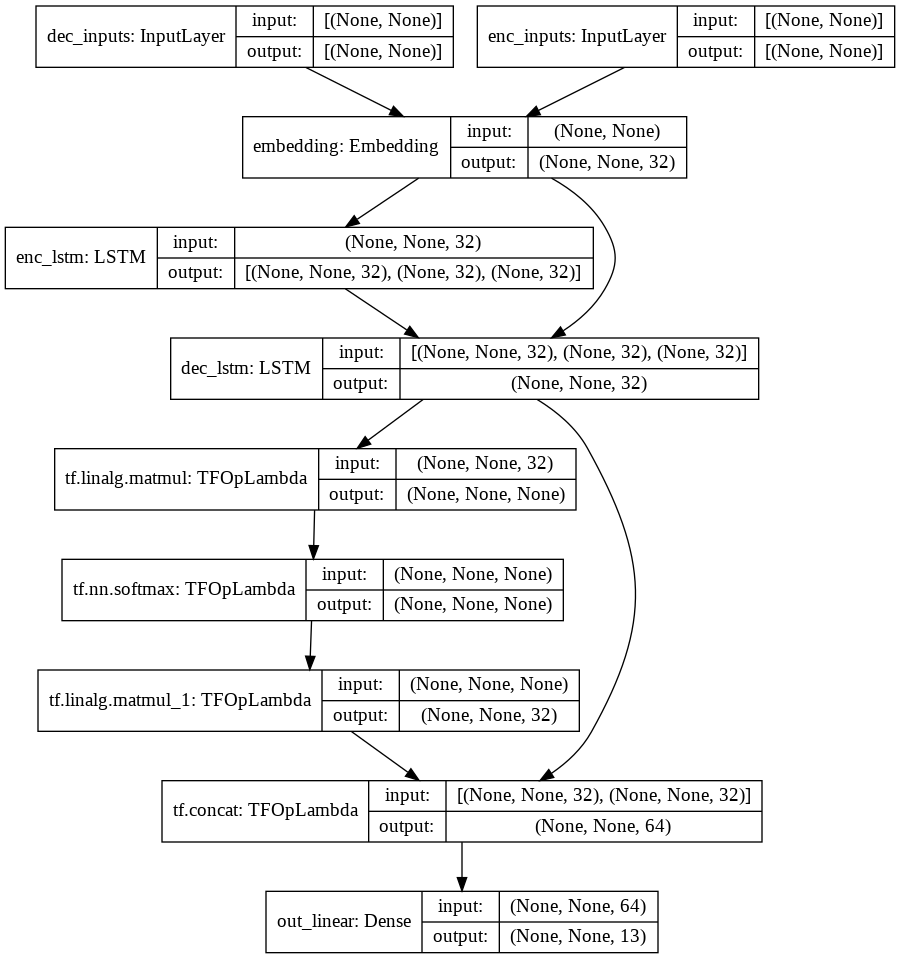

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_enc_inputs, train_dec_inputs))

array([[[0.07640307, 0.07717407, 0.07895681, 0.07690413, 0.0759858 ,
         0.07614148, 0.07750902, 0.07568109, 0.0775845 , 0.07707043,
         0.07657784, 0.07769681, 0.07631495],
        [0.07664734, 0.07691878, 0.07846681, 0.07730111, 0.07612614,
         0.07619733, 0.07702775, 0.07575921, 0.07744698, 0.07716408,
         0.07668602, 0.07755723, 0.07670119],
        [0.07711226, 0.07717799, 0.07806176, 0.07701518, 0.07606589,
         0.07628407, 0.0772878 , 0.07563908, 0.07778222, 0.07712504,
         0.07651297, 0.07680983, 0.07712592],
        [0.0776232 , 0.07667298, 0.07768542, 0.07670252, 0.07617043,
         0.07618449, 0.07652988, 0.0759107 , 0.07799137, 0.07734597,
         0.07729486, 0.07704251, 0.07684563],
        [0.07752907, 0.07728468, 0.07808127, 0.07698986, 0.07615297,
         0.07616232, 0.07726314, 0.07598674, 0.07788286, 0.07671013,
         0.07641358, 0.07669763, 0.07684574],
        [0.07742814, 0.07710431, 0.07790755, 0.07687847, 0.07619965,
         0.

# Vocabulary*

In [ ]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'kowiki', 'kowiki_32000.model'))

True

# Data*

In [ ]:
# 파일 다운로드 및 목록 확인
!wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv
os.listdir('./')

--2021-05-28 10:16:57--  https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv [following]
--2021-05-28 10:16:57--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘ChatbotData .csv’

ChatbotData .csv    100%[===================>] 868.99K  --.-KB/s    in 0.1s    

2021-05-28 10:16:58 (6.56 MB/s) - ‘ChatbotData .csv’ saved [889842/889842]



['.config', 'model.png', 'drive', 'ChatbotData .csv', 'sample_data']

In [ ]:
# 파일명 변경 및 목록 확인
!mv 'ChatbotData .csv' ChatbotData.csv
os.listdir('./') # 띄어쓰기 없앨겡ㅋ

['.config', 'model.png', 'drive', 'ChatbotData.csv', 'sample_data']

# Loss & Acc*

In [ ]:
def lm_loss(y_true, y_pred):
    """
    pad 부분을 제외하고 loss를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 loss 값
    """
    # loss = sparse_entropy = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    loss *= mask
    return loss

In [ ]:
def lm_acc(y_true, y_pred):
    """
    pad 부분을 제외하고 accuracy를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 accuracy 값
    """
    y_true = tf.cast(y_true, tf.float32)
    # print(y_true)
    y_pred_class = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    # print(y_pred_class)
    matches = tf.cast(tf.equal(y_true, y_pred_class), tf.float32)
    # print(matches)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    matches *= mask
    # print(matches)
    # accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(tf.ones_like(matches)), 1)
    accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(mask), 1)
    return accuracy

# All Data Project

## Train 데이터 생성

In [ ]:
# data load
df_train = pd.read_csv('ChatbotData.csv')
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [ ]:
# null 제거
df_train = df_train.dropna()
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [ ]:
# Q 길이
q_length = df_train["Q"].astype("str").apply(lambda x:len(vocab.encode_as_pieces(x)))
q_length.head(10), q_length.max()

(0     5
 1     6
 2     9
 3    10
 4     5
 5     7
 6     5
 7     7
 8    11
 9     9
 Name: Q, dtype: int64, 27)

In [ ]:
# A 길이
a_length = df_train["A"].astype("str").apply(lambda x:len(vocab.encode_as_pieces(x)))
a_length.head(10), a_length.max()

(0    6
 1    6
 2    6
 3    6
 4    9
 5    9
 6    9
 7    7
 8    6
 9    6
 Name: A, dtype: int64, 39)

In [ ]:
def make_data(df, vocab, n_enc_seq, n_dec_seq):
    """
    chat 학습 데이터 생성
    :param df: data frame
    :param df: vocab
    :param n_enc_seq: number of encoder sequence
    :param n_dec_seq: number of decoder sequence
    :return enc_inputs: encoder input data
    :return dec_inputs: decoder input data
    :return dec_labels: decoder label data
    """
    n_enc_max = n_enc_seq
    n_dec_max = n_dec_seq - 1  # [BOS] or [EOS]
    # inputa & labels
    enc_inputs = []
    dec_inputs = []
    dec_labels = []
    # 데이터 생성
    for i, row in tqdm(df.iterrows(), total=len(df)):
        Q = row['Q']
        A = row['A']
        # print(Q, '/', A)
        # tokenize
        tokens_q = vocab.encode_as_ids(Q)
        # print(len(tokens_q), ':', tokens_q)
        tokens_a = vocab.encode_as_ids(A)
        # print(len(tokens_a), ':', tokens_a)
        # 최대 길이로 자르기
        tokens_q = tokens_q[:n_enc_max]
        # print(len(tokens_q), ':', tokens_q)
        tokens_a = tokens_a[:n_dec_max]
        # print(len(tokens_a), ':', tokens_a)
        # input & label 정의
        enc_input = tokens_q
        # print(len(enc_input), ':', enc_input)
        dec_input = [vocab.bos_id()] + tokens_a
        # print(len(dec_input), ':', dec_input)
        dec_label = tokens_a + [vocab.eos_id()]
        # print(len(dec_label), ':', dec_label)
        # pad 추가
        enc_input += [0] * (n_enc_seq - len(enc_input))
        # print(len(enc_input), ':', enc_input)
        dec_input += [0] * (n_dec_seq - len(dec_input))
        # print(len(dec_input), ':', dec_input)
        dec_label += [0] * (n_dec_seq - len(dec_label))
        # print(len(dec_label), ':', dec_label)
        # 값 저장
        enc_inputs.append(enc_input)
        dec_inputs.append(dec_input)
        dec_labels.append(dec_label)
    # to numpy array
    enc_inputs = np.array(enc_inputs)
    dec_inputs = np.array(dec_inputs)
    dec_labels = np.array(dec_labels)
    return enc_inputs, dec_inputs, dec_labels

In [ ]:
train_enc_inputs, train_dec_inputs, train_dec_labels = make_data(df_train, vocab, 27, 40)
train_enc_inputs, train_dec_inputs, train_dec_labels

(array([[   92,    56,    10, ...,     0,     0,     0],
        [   36,    44,  1075, ...,     0,     0,     0],
        [   39,   999,   387, ...,     0,     0,     0],
        ...,
        [ 3531,  8607, 18488, ...,     0,     0,     0],
        [10149,  7479,  1232, ...,     0,     0,     0],
        [21584,    71,  1113, ...,     0,     0,     0]]),
 array([[    2,  2424,    19, ...,     0,     0,     0],
        [    2,  3975,    61, ...,     0,     0,     0],
        [    2,  1910,    18, ...,     0,     0,     0],
        ...,
        [    2,  1695,     1, ...,     0,     0,     0],
        [    2,   423,  9250, ...,     0,     0,     0],
        [    2, 14787,    98, ...,     0,     0,     0]]),
 array([[ 2424,    19,   345, ...,     0,     0,     0],
        [ 3975,    61,   976, ...,     0,     0,     0],
        [ 1910,    18,  8244, ...,     0,     0,     0],
        ...,
        [ 1695,     1,  8406, ...,     0,     0,     0],
        [  423,  9250,   507, ...,     0,    

## Modeling

In [ ]:
args.n_vocab = len(vocab)
args.d_model = 256
args

Namespace(d_model=256, n_vocab=32007, seed=1234)

In [ ]:
def build_model(args):
    enc_inputs = tf.keras.layers.Input((None,), name="enc_inputs")  # (bs, n_enc_seq)
    dec_inputs = tf.keras.layers.Input((None,), name="dec_inputs")  # (bs, n_dec_seq)
    ################################
    # Embedding
    ################################
    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model, name="embedding")
    enc_hidden = embedding(enc_inputs)  # (bs, n_enc_seq, d_model)
    dec_hidden = embedding(dec_inputs)  # (bs, n_dec_seq, d_model)
    ################################
    # Encoder
    ################################
    enc_lstm = tf.keras.layers.LSTM(units=args.d_model, return_state=True, name="enc_lstm")
    enc_hidden, enc_h_state, enc_c_state = enc_lstm(enc_hidden)  # (bs, n_enc_seq, units), (bs, units), (bs, units)
    ################################
    # Decoder
    ################################
    dec_lstm = tf.keras.layers.LSTM(units=args.d_model, return_sequences=True, name="dec_lstm")
    dec_hidden = dec_lstm(dec_hidden, initial_state=[enc_h_state, enc_c_state])  # (bs, n_dec_seq, units)
    ################################
    # Attention
    ################################
    attn_score = tf.matmul(dec_hidden, enc_hidden, transpose_b=True)  # (bs, n_dec_seq, n_enc_seq)
    attn_prob = tf.nn.softmax(attn_score, axis=-1)  # (bs, n_dec_seq, n_enc_seq)
    attn_out = tf.matmul(attn_prob, enc_hidden) # (bs, n_dec_seq, units)
    cat_hidden = tf.concat([attn_out, dec_hidden], axis=-1)  # (bs, n_dec_seq, units * 2)
    ################################
    # Next word prediction
    ################################
    linear = tf.keras.layers.Dense(args.n_vocab, activation=tf.nn.softmax, name="out_linear")
    y_pred = linear(cat_hidden)
    ################################
    # Model
    ################################
    model = tf.keras.Model(inputs=(enc_inputs, dec_inputs), outputs=y_pred)
    return model

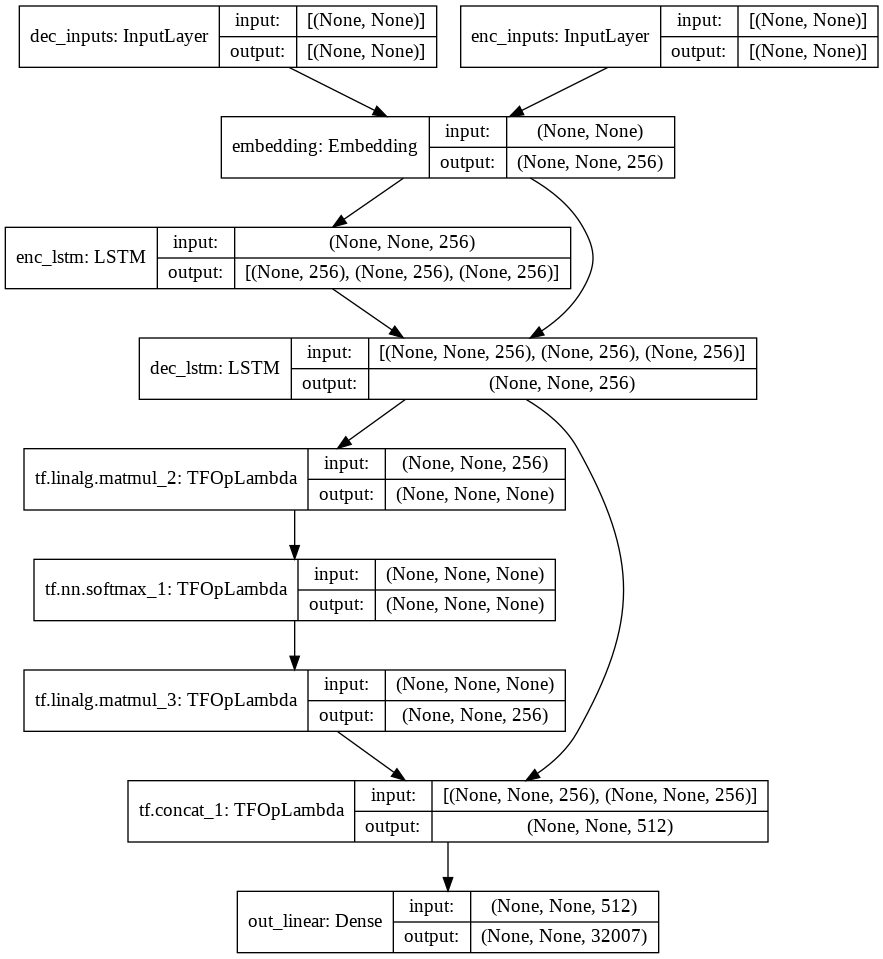

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_enc_inputs[:4], train_dec_inputs[:4]))

array([[[3.1064279e-05, 3.1148342e-05, 3.1195428e-05, ...,
         3.1248623e-05, 3.1232146e-05, 3.1253676e-05],
        [3.1086631e-05, 3.1165764e-05, 3.1190750e-05, ...,
         3.1274081e-05, 3.1247273e-05, 3.1275638e-05],
        [3.1123025e-05, 3.1146315e-05, 3.1173844e-05, ...,
         3.1284315e-05, 3.1253723e-05, 3.1273430e-05],
        ...,
        [3.1049865e-05, 3.1107680e-05, 3.1108822e-05, ...,
         3.1268479e-05, 3.1284773e-05, 3.1363703e-05],
        [3.1049836e-05, 3.1107669e-05, 3.1108881e-05, ...,
         3.1268388e-05, 3.1284791e-05, 3.1363816e-05],
        [3.1049811e-05, 3.1107658e-05, 3.1108935e-05, ...,
         3.1268315e-05, 3.1284810e-05, 3.1363910e-05]],

       [[3.1064308e-05, 3.1148807e-05, 3.1195781e-05, ...,
         3.1248619e-05, 3.1231397e-05, 3.1253679e-05],
        [3.1058848e-05, 3.1150925e-05, 3.1168816e-05, ...,
         3.1263535e-05, 3.1225558e-05, 3.1285155e-05],
        [3.1081971e-05, 3.1129191e-05, 3.1156302e-05, ...,
         3.128

## Train

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss=lm_loss, optimizer="adam", metrics=[lm_acc])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=30)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(sychat_dir, "lstm_dot.hdf5"),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(sychat_dir, "lstm_dot.csv"))

In [ ]:
history = model.fit((train_enc_inputs, train_dec_inputs),
                    train_dec_labels,
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
47/47 [==============================] - 25s 453ms/step - loss: 1.6461 - lm_acc: 0.1059

Epoch 00001: lm_acc improved from -inf to 0.10593, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/songys-chat/lstm_dot.hdf5
Epoch 2/100
47/47 [==============================] - 22s 469ms/step - loss: 1.2968 - lm_acc: 0.1595

Epoch 00002: lm_acc improved from 0.10593 to 0.15948, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/songys-chat/lstm_dot.hdf5
Epoch 3/100
47/47 [==============================] - 22s 477ms/step - loss: 1.1887 - lm_acc: 0.2596

Epoch 00003: lm_acc improved from 0.15948 to 0.25959, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/songys-chat/lstm_dot.hdf5
Epoch 4/100
47/47 [==============================] - 22s 464ms/step - loss: 1.1242 - lm_acc: 0.2858

Epoch 00004: lm_acc improved from 0.25959 to 0.28580, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/songys-chat/lstm_

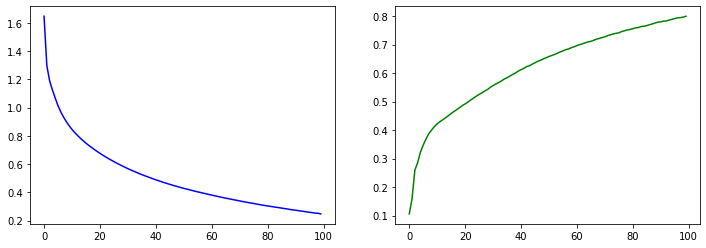

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='accuracy')

plt.show()

## BLEU

In [ ]:
def get_ngram(tokens, ngram):
    # tokens n-gram
    counter = collections.defaultdict(int)
    for i in range(len(tokens) - ngram + 1):
        # n-gram 별 count
        key = tuple(tokens[i:i+ngram])
        counter[key] += 1
    return  counter

In [ ]:
def get_ngram_clip(candidate, references, ngram):
    # max ref counter
    max_counter = collections.defaultdict(int)
    # check max count
    for ref in references:
        ref_counter = get_ngram(ref, ngram)
        for key, cnt in ref_counter.items():
            max_counter[key] = max(max_counter[key], ref_counter.get(key, 0))
    
    # candidate counter
    can_counter = get_ngram(candidate, ngram)
    # clip counter
    clip_counter = collections.defaultdict(int)
    for key, cnt in can_counter.items():
        clip_counter[key] = min(can_counter[key], max_counter.get(key, 0))
    return clip_counter

In [ ]:
def get_ngram_precision(candidate, references, ngram):
    # clip counter
    clip_counter = get_ngram_clip(candidate, references, ngram) 
    n_clip = sum(clip_counter.values())
    # ref counter
    can_counter = get_ngram(candidate, ngram)
    n_total = sum(can_counter.values())

    return n_clip / max(n_total, 1)  # 분모 0 방지

In [ ]:
def get_brevity_penalty(candidate, references):
    can_len = len(candidate)
    ref_len = min([len(reference) for reference in references])

    if can_len == 0:  # empty string
        return 0
    elif can_len > ref_len:
        return 1
    else:
        return np.exp(1 - ref_len / can_len)

In [ ]:
def get_bleu_score(candidate, references, weights=[0.25, 0.25, 0.25, 0.25]):
    bp = get_brevity_penalty(candidate, references) # BP
    p_n = []
    for i in range(len(weights)):
        p_n.append(get_ngram_precision(candidate, references, i + 1))
    score = [w * np.log(p) if p != 0 else 0 for p, w in zip(p_n, weights)]
    score = np.sum(score)
    score = bp * np.exp(score)
    return score

In [ ]:
import nltk.translate.bleu_score as bleu
from nltk import ngrams

## 평가

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(sychat_dir, "lstm_dot.hdf5"))

In [ ]:
model.compile(loss=lm_loss, optimizer="adam", metrics=[lm_acc])

In [ ]:
# 100개만 확인
valid_enc_inputs = train_enc_inputs[:100]
valid_dec_inputs = train_dec_inputs[:100]
valid_dec_labels = train_dec_labels[:100]

In [ ]:
# 평가
model.evaluate((valid_enc_inputs, valid_dec_inputs), valid_dec_labels, batch_size=128)

1/1 [==============================] - 1s 1s/step - loss: 0.1921 - lm_acc: 0.8414


[0.19209447503089905, 0.8414239287376404]

In [ ]:
references = []
for row in valid_dec_labels:
    ids = []
    for i in row:
        if i == vocab.eos_id():
            break
        ids.append(int(i))
    string = vocab.id_to_piece(ids)
    references.append(string)
references

[['▁하루', '가', '▁또', '▁가네', '요', '.'],
 ['▁위로', '해', '▁드', '립', '니다', '.'],
 ['▁여행', '은', '▁언제나', '▁좋', '죠', '.'],
 ['▁여행', '은', '▁언제나', '▁좋', '죠', '.'],
 ['▁눈', '살이', '▁', '찌', '푸', '려', '지', '죠', '.'],
 ['▁다시', '▁새로', '▁사는', '▁게', '▁마음', '▁편', '해', '요', '.'],
 ['▁다시', '▁새로', '▁사는', '▁게', '▁마음', '▁편', '해', '요', '.'],
 ['▁잘', '▁모르고', '▁있을', '▁수도', '▁있어', '요', '.'],
 ['▁시간을', '▁정하고', '▁해', '보', '세요', '.'],
 ['▁시간을', '▁정하고', '▁해', '보', '세요', '.'],
 ['▁자랑하는', '▁자리', '니까', '요', '.'],
 ['▁그', '▁사람도', '▁그럴', '▁거', '예', '요', '.'],
 ['▁그', '▁사람도', '▁그럴', '▁거', '예', '요', '.'],
 ['▁혼자', '를', '▁즐기', '세요', '.'],
 ['▁돈', '은', '▁다시', '▁들어올', '▁거', '예', '요', '.'],
 ['▁땀', '을', '▁식', '혀', '주', '세요', '.'],
 ['▁', '어서', '▁', '잊', '고', '▁새', '출', '발', '▁하', '세요', '.'],
 ['▁빨리', '▁집에', '▁돌아가', '서', '▁끄', '고', '▁나오', '세요', '.'],
 ['▁빨리', '▁집에', '▁돌아가', '서', '▁끄', '고', '▁나오', '세요', '.'],
 ['▁다음', '▁달', '에는', '▁더', '▁절약', '해', '봐', '요', '.'],
 ['▁따뜻하', '게', '▁사', '세요', '!'],
 ['▁다음', '▁달', '에는', '▁더', '▁절약', 

In [ ]:
# 예측
y_pred = model.predict((valid_enc_inputs, valid_dec_inputs))
y_pred

array([[[8.82112072e-09, 2.12228747e-06, 7.65261721e-09, ...,
         7.07499037e-09, 2.65199169e-08, 8.64424532e-09],
        [3.83470233e-09, 7.44930003e-05, 3.88405086e-09, ...,
         3.10250003e-09, 3.59265506e-08, 3.69877928e-09],
        [1.14420362e-09, 6.66978076e-06, 1.21349297e-09, ...,
         1.00338993e-09, 5.50792379e-07, 1.12483922e-09],
        ...,
        [6.31473807e-09, 1.78466649e-07, 5.58460078e-09, ...,
         6.55055210e-09, 8.29490546e-06, 7.42898010e-09],
        [7.09363768e-09, 1.96826022e-07, 6.22291108e-09, ...,
         7.36974703e-09, 1.63973855e-05, 8.40312175e-09],
        [8.32076186e-09, 2.37439750e-07, 7.25997573e-09, ...,
         8.64371152e-09, 3.07671326e-05, 9.91709914e-09]],

       [[2.04701838e-08, 7.02763998e-07, 2.03824069e-08, ...,
         1.92867446e-08, 3.58524122e-09, 1.97207637e-08],
        [1.74649628e-10, 2.91534352e-08, 1.69978309e-10, ...,
         1.59019700e-10, 3.79215909e-10, 1.75044479e-10],
        [4.79765117e-10, 

In [ ]:
# greedy decoding
y_pred_class = tf.argmax(y_pred, axis=-1).numpy()
y_pred_class

array([[ 1025,    19,   345, ...,  2944,  2944, 26829],
       [  423,    15,   976, ...,  2944,  2944,  2944],
       [ 1232,    18,  8244, ..., 26829, 26829,     9],
       ...,
       [  983,    20,   506, ...,  2944,  2944,  2944],
       [   10,    20,  2489, ...,  2944,  2944,  2944],
       [ 2944,  4853,  1316, ..., 26829, 26829,  2944]])

In [ ]:
candidates = []
for row in y_pred_class:
    ids = []
    for i in row:
        if i == vocab.eos_id():
            break
        ids.append(int(i))
    string = vocab.id_to_piece(ids)
    candidates.append(string)
candidates

[['▁저', '가', '▁또', '▁가네', '요', '.'],
 ['▁잘', '를', '▁드', '립', '니다', '.'],
 ['▁좋은', '은', '▁언제나', '▁좋', '죠', '.'],
 ['▁좋은', '은', '▁언제나', '▁좋', '죠', '.'],
 ['▁좋은', '을', '▁', '찌', '푸', '려', '지', '죠', '.'],
 ['▁', '▁아침', '▁사는', '▁게', '▁있어', '▁편', '해', '요', '.'],
 ['▁', '▁아침', '▁사는', '▁게', '▁있어', '▁편', '해', '요', '.'],
 ['▁먼저', '하고', '▁있을', '▁수도', '▁있어', '요', '.'],
 ['▁그런', '▁정하고', '▁해', '보', '세요', '.'],
 ['▁그런', '▁정하고', '▁해', '보', '세요', '.'],
 ['▁', '▁자리', '니까', '요', '.'],
 ['▁', '게', '▁당신', '▁거', '예', '요', '.'],
 ['▁', '▁사람', '▁당신', '▁거', '예', '요', '.'],
 ['▁', '만', '▁즐기', '세요', '.'],
 ['▁좋은', '은', '▁다시', '▁들어올', '▁거', '예', '요', '.'],
 ['▁좋은', '을', '▁식', '혀', '주', '세요', '.'],
 ['▁', '괜', '▁따', '잊', '고', '▁새', '출', '발', '▁하', '세요', '.'],
 ['▁', '▁집에', '▁돌아가', '서', '▁끄', '고', '▁나오', '세요', '.'],
 ['▁', '▁집에', '▁돌아가', '서', '▁끄', '고', '▁나오', '세요', '.'],
 ['▁저', '에는', '에는', '▁더', '▁절약', '해', '봐', '요', '.'],
 ['▁좋은', '게', '▁사', '세요', '!'],
 ['▁저', '에는', '에는', '▁더', '▁절약', '해', '봐', '요', '.'],
 ['▁사

In [ ]:
bleu_scores = []
for reference, candidate in zip(references, candidates):
    bleu_score = bleu.sentence_bleu([reference], candidate)
    bleu_scores.append(bleu_score)
    print(bleu_score, ":", reference, "/", candidate)
np.mean(bleu_scores)

0.7598356856515925 : ['▁하루', '가', '▁또', '▁가네', '요', '.'] / ['▁저', '가', '▁또', '▁가네', '요', '.']
0.5081327481546147 : ['▁위로', '해', '▁드', '립', '니다', '.'] / ['▁잘', '를', '▁드', '립', '니다', '.']
0.7598356856515925 : ['▁여행', '은', '▁언제나', '▁좋', '죠', '.'] / ['▁좋은', '은', '▁언제나', '▁좋', '죠', '.']
0.7598356856515925 : ['▁여행', '은', '▁언제나', '▁좋', '죠', '.'] / ['▁좋은', '은', '▁언제나', '▁좋', '죠', '.']
0.7259795291154771 : ['▁눈', '살이', '▁', '찌', '푸', '려', '지', '죠', '.'] / ['▁좋은', '을', '▁', '찌', '푸', '려', '지', '죠', '.']
0.3549481056010053 : ['▁다시', '▁새로', '▁사는', '▁게', '▁마음', '▁편', '해', '요', '.'] / ['▁', '▁아침', '▁사는', '▁게', '▁있어', '▁편', '해', '요', '.']
0.3549481056010053 : ['▁다시', '▁새로', '▁사는', '▁게', '▁마음', '▁편', '해', '요', '.'] / ['▁', '▁아침', '▁사는', '▁게', '▁있어', '▁편', '해', '요', '.']
0.6147881529512643 : ['▁잘', '▁모르고', '▁있을', '▁수도', '▁있어', '요', '.'] / ['▁먼저', '하고', '▁있을', '▁수도', '▁있어', '요', '.']
0.7598356856515925 : ['▁시간을', '▁정하고', '▁해', '보', '세요', '.'] / ['▁그런', '▁정하고', '▁해', '보', '세요', '.']
0.7598356856515925 : 

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.7153684634947307

## 배포

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(sychat_dir, "lstm_dot.hdf5"))

In [ ]:
def do_chat(vocab, model, n_dec_seq, string):
    """
    seq2seq chat
    :param vocab: vocab
    :param model: model
    :param n_dec_seq: number of dec seqence
    :param string: inpust string
    """
    # qeustion
    q = vocab.encode_as_pieces(string)
    q_id = [vocab.piece_to_id(p) for p in q]
    q_id += [0] * (27 - len(q_id)) # pad를 넣어줌
    #아 이게 학습할때는 padding까지 잘들어간 data로 학습을 했지만
    # 실제 저희가 학습된 모델을 사용할때 들어간 q는 padding이 들어가지 않은 상태로 들어가서 이전에 없었던 패턴으로 인식해서 잘 안된상태라는 말씀이시죠?
    
    assert len(q_id) == 27
    # answer
    a_id = [vocab.bos_id()]

    # 처음부터 예측
    start_idx = 0

    for _ in range(start_idx, n_dec_seq - 1):
        # print(q_id)
        # print(a_id)
        outputs = model.predict((np.array([q_id]), np.array([a_id])))
        prob = outputs[0][start_idx]
        word_id = int(np.argmax(prob))
        # print(word_id)
        if word_id == vocab.eos_id():
            break
        a_id.append(word_id)
        start_idx += 1
    predict_id = a_id[1:start_idx + 1]
    # print(predict_id)
    predict_str = vocab.decode_ids(predict_id)
    return predict_str

In [ ]:
string = '남에게 피해주지 않는 건 기본이죠.'
do_chat(vocab, model, 40, string)

'아무것도 안해도 재밌을 거예요.'

In [ ]:
while True:
    string = input('질문 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_chat(vocab, model, 40, string)
    print(f'답변 > {predict_str}')

질문 > 안녕
답변 > 제가 아직 많이 부족합니다.
질문 > 무엇이 부족하니
답변 > 그게 최고죠.
질문 > 너는 누구니
답변 > 괜찮아요.
질문 > 뭐가 괜찮아?
답변 > 연락해도 상관없지만 자신을 비하하지는 마세요.
질문 > 무슨 말이야?
답변 > 사랑은 따지는 게 아니고 다 주고도 더 주지 못해 미안해하는 거예요.
질문 > 기분이 좋아
답변 > 저도요!
